In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

In [15]:
edges_df = pd.read_csv("./wits2/tmp/2011/el_no_missing.csv")
locations_df = pd.read_csv("./wits2/data/common/locations.csv")
nodes_df = pd.read_csv("./wits2/tmp/2011/nl_no_missing.csv")

In [16]:
edges_df = pd.read_csv("./wits2/data/2011/edgelist_threshold.csv")

In [17]:
edges_df

,source,target,weight
0,MEX,COL,5.628647e+06
1,MEX,CAN,1.043998e+07
2,MEX,PRT,3.321739e+05
3,MEX,ARE,3.532589e+05
4,MEX,HND,4.997932e+05
...,...,...,...
3412,BIH,AUT,4.402657e+05
3413,BIH,ITA,6.855669e+05
3414,BIH,SVN,5.028449e+05
3415,BIH,HRV,8.568068e+05


In [18]:
#nodes_df.set_index('country_iso3', inplace=True)

In [19]:
nodes_df

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,area,landlocked,continent,langoff_1,population,gdp_per_capita,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows
0,AFG,1.780429e+10,11.804186,0.426355,652225,1,Asia,Persian,30117411,591.162798,23.743664,22.740252,38.704149,144.751869,5.217342e+07
1,AGO,1.117897e+11,13.482468,3.471976,1246700,0,Africa,Portuguese,24220660,4615.468219,5.845681,56.026515,78.305971,244.329152,-3.023771e+09
2,ALB,1.289077e+10,3.429123,2.545322,28748,0,Europe,Albanian,2905195,4437.142885,18.226765,24.484408,56.862411,94.337202,1.048707e+09
3,ARE,3.506660e+11,0.877347,6.930272,83657,0,Asia,Arabic,8946778,39194.672240,0.671910,58.035599,151.702461,176.149781,7.152096e+09
4,ARG,5.301633e+11,9.800000,6.003952,2766889,0,America,Spanish,41261490,12848.864197,6.998734,25.212698,29.871929,160.564925,1.083993e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,WSM,7.374017e+08,5.235416,4.173393,2842,0,Pacific,Samoan,187469,3933.459357,8.836995,18.584138,55.871854,80.565436,8.984743e+06
162,YEM,3.272642e+10,19.543562,-12.714823,547244,0,Asia,Arabic,23807586,1374.621401,8.533169,46.466096,64.046119,171.430685,-5.178429e+08
163,ZAF,4.164189e+11,5.017158,3.284168,1219912,0,Africa,English,52003759,8007.476439,2.285473,26.942540,56.012110,146.294834,4.139289e+09
164,ZMB,2.345952e+10,6.429397,5.564602,752614,1,Africa,English,14023199,1672.907535,9.648058,34.444282,68.965619,197.447040,1.108500e+09


In [20]:
attribute_dict = nodes_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()


In [21]:
#Drop edges that specify internal trade
edges_df.drop(edges_df[edges_df['source'] == edges_df['target']].index, inplace=True)

In [22]:
nodes_df = pd.merge(left=nodes_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries = nodes_df['country_iso3'].unique()

In [23]:
g = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [55]:
nodes_df

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,area,landlocked,continent,langoff_1,population,gdp_per_capita,...,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows,Country,Alpha-2code,Alpha-3code,Numericcode,Latitude(average),Longitude(average)
0,AFG,1.780429e+10,11.804186,0.426355,652225,1,Asia,Persian,30117411,591.162798,...,22.740252,38.704149,144.751869,5.217342e+07,Afghanistan,AF,AFG,4,33.0000,65.0000
1,AGO,1.117897e+11,13.482468,3.471976,1246700,0,Africa,Portuguese,24220660,4615.468219,...,56.026515,78.305971,244.329152,-3.023771e+09,Angola,AO,AGO,24,-12.5000,18.5000
2,ALB,1.289077e+10,3.429123,2.545322,28748,0,Europe,Albanian,2905195,4437.142885,...,24.484408,56.862411,94.337202,1.048707e+09,Albania,AL,ALB,8,41.0000,20.0000
3,ARE,3.506660e+11,0.877347,6.930272,83657,0,Asia,Arabic,8946778,39194.672240,...,58.035599,151.702461,176.149781,7.152096e+09,UnitedArabEmirates,AE,ARE,784,24.0000,54.0000
4,ARG,5.301633e+11,9.800000,6.003952,2766889,0,America,Spanish,41261490,12848.864197,...,25.212698,29.871929,160.564925,1.083993e+10,Argentina,AR,ARG,32,-34.0000,-64.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,WSM,7.374017e+08,5.235416,4.173393,2842,0,Pacific,Samoan,187469,3933.459357,...,18.584138,55.871854,80.565436,8.984743e+06,Samoa,WS,WSM,882,-13.5833,-172.3333
172,YEM,3.272642e+10,19.543562,-12.714823,547244,0,Asia,Arabic,23807586,1374.621401,...,46.466096,64.046119,171.430685,-5.178429e+08,Yemen,YE,YEM,887,15.0000,48.0000
173,ZAF,4.164189e+11,5.017158,3.284168,1219912,0,Africa,English,52003759,8007.476439,...,26.942540,56.012110,146.294834,4.139289e+09,SouthAfrica,ZA,ZAF,710,-29.0000,24.0000
174,ZMB,2.345952e+10,6.429397,5.564602,752614,1,Africa,English,14023199,1672.907535,...,34.444282,68.965619,197.447040,1.108500e+09,Zambia,ZM,ZMB,894,-15.0000,30.0000


In [56]:
nodes_df.set_index('country_iso3')['foreign_direct_investment_inflows'].to_dict()
nx.set_node_attributes(g, attribute_dict, 'foreign_direct_investment_inflows')

In [ ]:
nx.set_node_attributes(g, attribute_dict, 'gdp')

In [25]:
el = pd.read_csv("./wits2/data/2011/edgelist_threshold.csv")

In [57]:
# Convert NetworkX graph to PyG Data object
data = from_networkx(g, group_edge_attrs=['weight'], group_node_attrs=['gdp', 'foreign_direct_investment_inflows'])


In [58]:
data

Data(edge_index=[2, 3417], x=[154, 2], edge_attr=[3417, 1])

In [59]:
data.num_features

2

In [60]:
graph = to_networkx(data, node_attrs=["x"])

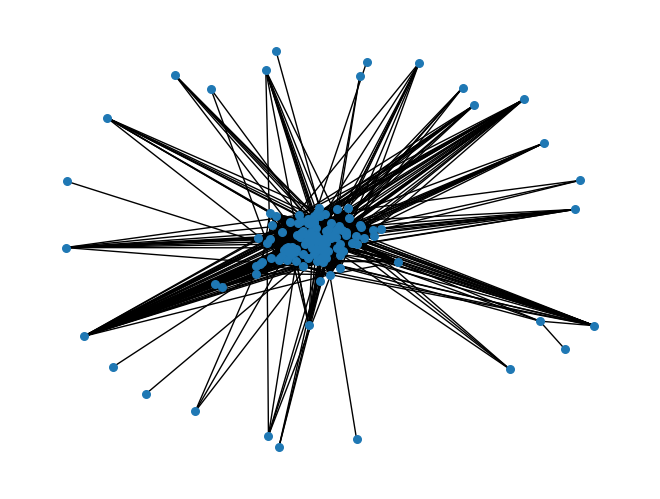

In [61]:
nx.draw_spring(graph, node_size=30, arrows=False)

In [96]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index):
        z = model.encode(x, edge_index)
        return model.decode(z, edge_label_index).view(-1)


model = GCN(data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)


In [81]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

In [82]:
def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [83]:
def norm(data, method = 'minimax'):
    if method == 'minimax':
        return (data - data.min()) / (data.max() - data.min())

In [84]:

data.x = norm(data.x)

In [85]:
data.x[0]

tensor([0.0759, 0.0759])

In [86]:
data.x.max()

tensor(1.)

In [87]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(data)

In [88]:
model = Net(data.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.626, Val AUC: 0.911
Epoch: 020, Train Loss: 0.578, Val AUC: 0.910
Epoch: 030, Train Loss: 0.549, Val AUC: 0.860
Epoch: 040, Train Loss: 0.536, Val AUC: 0.860
Epoch: 050, Train Loss: 0.539, Val AUC: 0.862
Epoch: 060, Train Loss: 0.536, Val AUC: 0.867
Epoch: 070, Train Loss: 0.542, Val AUC: 0.873
Epoch: 080, Train Loss: 0.531, Val AUC: 0.875
Epoch: 090, Train Loss: 0.541, Val AUC: 0.877
Epoch: 100, Train Loss: 0.528, Val AUC: 0.889
Test: 0.895


In [97]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
model_config = ModelConfig(
    mode='binary_classification',
    task_level='edge',
    return_type='raw',
)

In [98]:
# Explain model output for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]

In [99]:
explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)

In [101]:
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_label_index=edge_label_index
)
print(f'Generated model explanations in {explanation.available_explanations}')

Generated model explanations in ['edge_mask', 'node_mask']


In [102]:
# Explain a selected target (phenomenon) for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]
target = val_data.edge_label[0].unsqueeze(dim=0).long()

In [103]:
explainer = Explainer(
    model=model,
    explanation_type='phenomenon',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    target=target,
    edge_label_index=edge_label_index,
)
available_explanations = explanation.available_explanations
print(f'Generated phenomenon explanations in {available_explanations}')

Generated phenomenon explanations in ['edge_mask', 'node_mask']


In [105]:
edge_label_index

tensor([ 16, 116])

In [106]:
target

tensor([1])

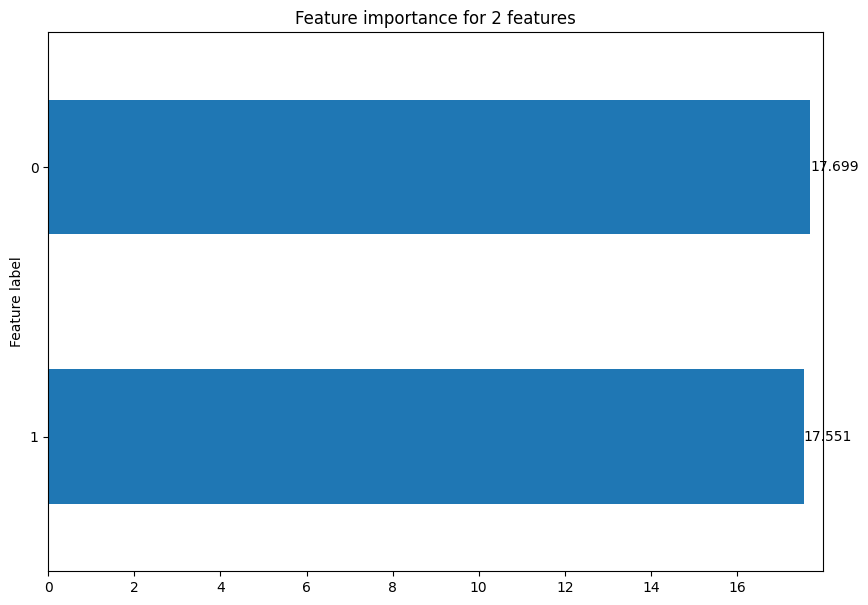

In [108]:
explanation.visualize_feature_importance()

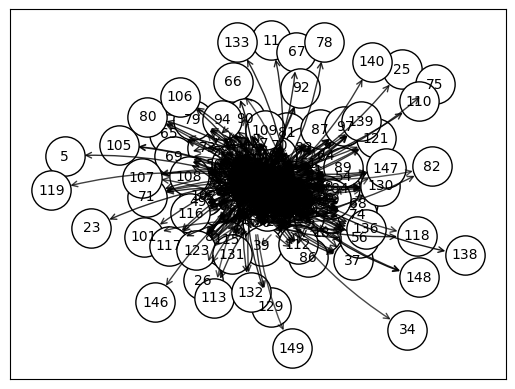

In [109]:
explanation.visualize_graph()